# DCGAN implemented on MXNet Gluon

In [1]:
from __future__ import print_function
import os
import math
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.misc

## Prerequisites for Scripting

1) Install Pillow

!pip install pillow

2) Obtain the Dataset via the Google Drive link:
https://drive.google.com/open?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

Website is at http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

3) Extract the zip file to datasets

```
 cd SageMaker/face_generation
 mkdir dataset
 cd dataset
 unzip ../img_align_celeba.zip
 
```

4) Make an output directory
```
mkdir output
```

## Initialize the hyper parameters

In [2]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

manualSeed = random.randint(1, 10000) # manual seed 
mx.random.seed(manualSeed)



## Load the Data

In [3]:
imageSize = 64     # the height / width of the input image to network'

def transformer(data, label):
    data = mx.image.imresize(data, imageSize, imageSize)
    data = mx.nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/128.0-1.0 
    return data, label

## Create a data iterator

In [4]:
batchSize = 64

dataroot = './dataset'
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(dataroot,transform=transformer),
    batch_size= batchSize, shuffle=True, last_batch='discard')

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(dataroot, transform=transformer),
    batch_size=batchSize, shuffle=False, last_batch='discard')
    


## Create the Generator and Discriminator networks

![Generator Photo](./Gen.png)
![Generator and Discriminator Photo](./DG.jpeg)
Source: Radford, et al. 2015 (https://arxiv.org/abs/1511.06434)

In [6]:
G_Net = gluon.nn.Sequential()
nz = 100           # size of the latent z vector (tbe "noise" dimension)
ngf = 64
ndf = 64 
nc = 3             # Number of colors (Num input channels)

with G_Net.name_scope():
    # First layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*8, kernel_size=4, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Second layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*4, kernel_size=4, strides = 2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Third layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf*2, kernel_size=4, strides=2,
                                       padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    
    # Fourth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=ngf, kernel_size=4, strides = 2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    G_Net.add(gluon.nn.Activation('relu'))
    # Fifth layer
    G_Net.add(gluon.nn.Conv2DTranspose(channels=nc, kernel_size=4, strides=2, padding=1, use_bias=False))
    G_Net.add(gluon.nn.Activation('tanh'))

    
    
D_Net = gluon.nn.Sequential()
with D_Net.name_scope():
    # First layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Second layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*2, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1, center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Third layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*4, kernel_size=4,strides=2,padding=1,use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Fourth layer
    D_Net.add(gluon.nn.Conv2D(channels=ndf*8, kernel_size=4, strides=2, padding=1, use_bias=False))
    D_Net.add(gluon.nn.BatchNorm(axis = 1, momentum = 0.1,center=True))
    D_Net.add(gluon.nn.LeakyReLU(0.2))
    
    # Fifth layer
    D_Net.add(gluon.nn.Conv2D(channels=1, kernel_size=4, strides=2, padding=0, use_bias=False))
    D_Net.add(gluon.nn.Activation('sigmoid'))
    
g_net = G_Net
d_net = D_Net

## A function to visualizing the created and real images

In [7]:
outf = './output'
def image_show(data,padding = 2):
    datanp = np.clip((data.asnumpy().transpose((0, 2, 3, 1)) + 1.0)*128.0,0,255).astype(np.uint8)
    
    x_dim = min(8, batchSize)
    y_dim = int(math.ceil(float(batchSize) / x_dim))
    height, width = int(imageSize + padding), int(imageSize + padding)
    grid = np.zeros(( height * y_dim + 1 + padding // 2, width * x_dim + 1 + padding // 2,3),dtype = np.uint8)
    k = 0
    for y in range(y_dim):
        for x in range(x_dim):
            if k >= batchSize:
                break
            start_y = y * height + 1 + padding // 2
            end_y = start_y + height - padding 
            start_x = x * width + 1 + padding // 2
            end_x = start_x + width - padding
            np.copyto(grid[start_y:end_y,start_x:end_x,:],datanp[k])
            k = k + 1
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(grid)
    plt.show()
    scipy.misc.imsave('%s/fake_samples_epoch_%03d.png' % (outf, epoch),grid)
#    plt.savefig('%s/%s/fake_samples_epoch_%03d.png' % (outf,dataset, epoch))
def binary_cross_entropy(yhat, y):
    return - (y * nd.log(yhat) + (1 - y ) * nd.log(1 - yhat))

## Initialize the networks and the optimizers

In [8]:
#Initialization
lr = 0.0001 # learning rate, default=0.0002
beta1 = 0.5 # beta1 for adam
beta2 = 0.999 # beta2 for adam
clip_gradient = 10.0

g_net.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
d_net.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
G_trainer = gluon.Trainer(g_net.collect_params(), 'Adam', {'learning_rate': lr * 10,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})
D_trainer = gluon.Trainer(d_net.collect_params(), 'Adam', {'learning_rate': lr,'beta1':beta1,'beta2':beta2,'clip_gradient':clip_gradient})



## The learning loop - Attemp 1

[0/0/125][0/623] Loss_D: 1.0896 Loss_G: 0.0602 D(x): 0.5413 D(G(z)): 0.9425


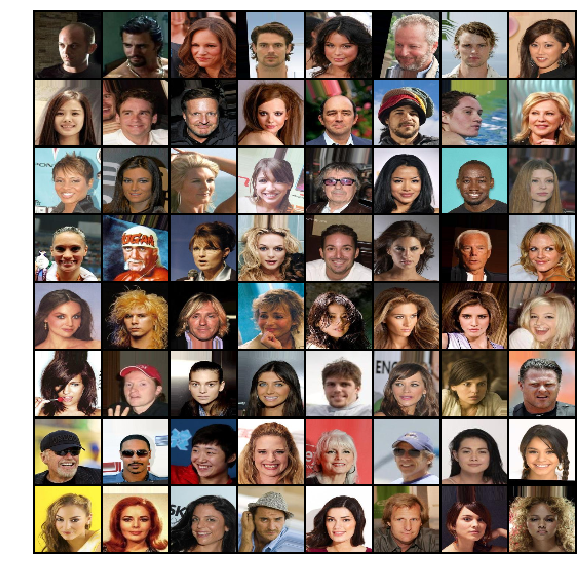

/home/ANT.AMAZON.COM/vishaalk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


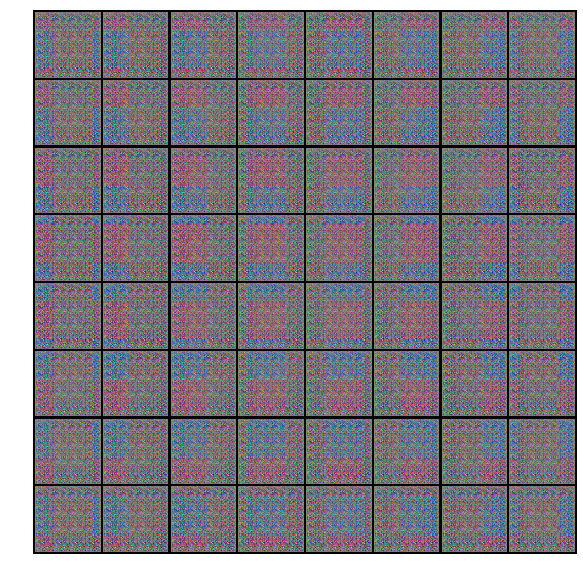

[0/1/125][1/623] Loss_D: 0.8312 Loss_G: 0.0308 D(x): 0.6479 D(G(z)): 0.9701
[0/1/125][2/623] Loss_D: 0.6674 Loss_G: 0.0139 D(x): 0.6719 D(G(z)): 0.9863
[0/1/125][3/623] Loss_D: 0.4609 Loss_G: 0.0046 D(x): 0.7969 D(G(z)): 0.9954
[0/1/125][4/623] Loss_D: 0.2646 Loss_G: 0.0020 D(x): 0.8632 D(G(z)): 0.9980
[0/1/125][5/623] Loss_D: 0.3597 Loss_G: 0.0014 D(x): 0.8124 D(G(z)): 0.9986
[0/1/125][6/623] Loss_D: 0.3533 Loss_G: 0.0010 D(x): 0.8618 D(G(z)): 0.9990
[0/1/125][7/623] Loss_D: 0.1831 Loss_G: 0.0007 D(x): 0.9174 D(G(z)): 0.9993
[0/1/125][8/623] Loss_D: 0.1596 Loss_G: 0.0007 D(x): 0.8919 D(G(z)): 0.9993
[0/1/125][9/623] Loss_D: 0.0744 Loss_G: 0.0005 D(x): 0.9372 D(G(z)): 0.9995
[0/1/125][10/623] Loss_D: 0.3392 Loss_G: 0.0005 D(x): 0.8484 D(G(z)): 0.9995
[0/1/125][11/623] Loss_D: 0.1216 Loss_G: 0.0003 D(x): 0.9136 D(G(z)): 0.9997
[0/1/125][12/623] Loss_D: 0.2009 Loss_G: 0.0003 D(x): 0.8928 D(G(z)): 0.9997


KeyboardInterrupt: 

In [11]:
epochs = 125 # number of epochs to train for

g_net.collect_params().zero_grad()
d_net.collect_params().zero_grad()
counter = 0
for epoch in range(epochs):
    for i, (d, _ ) in enumerate(train_data):
        
        # Update Discriminator
        data = d.as_in_context(ctx)
        label = nd.ones(batchSize, ctx)
        noise = nd.normal(loc=0, scale=1, shape = (batchSize, nz,1,1),ctx = ctx)
        with autograd.record():     
            
            # Pass Real Image Data through the Network
            output = d_net(data)
            
            # Compute the Error. All Real data has label "1" for Real
            D_error = nd.mean(binary_cross_entropy(output,label))
            
            # Compute the mean output
            D_x = nd.mean(output)
            
            D_error.backward()
            
        # Update Weights on Trainer.
        D_trainer.step(batchSize)
        
        # Update Generator
        label = nd.ones(batchSize, ctx)
        with autograd.record():
            # Pass noise through Generator
            fake_image = g_net(noise)
            
            # Pass counterfeit images through Discriminator
            output = d_net(fake_image)
            
            # Compute Error
            G_error = nd.mean(binary_cross_entropy(output,label))
            
            # Mean discriminator output on generated image
            D_G_z = nd.mean(output)
            
            # Backpropagate
            G_error.backward()
        G_trainer.step(batchSize)
        
        
        print('[%d/%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
              % (epoch,counter, epochs, i, len(train_data),
                 D_error.asnumpy(), G_error.asnumpy(), D_x.asnumpy(), D_G_z.asnumpy()))
        trunctate = 1
        if i % (100 * trunctate) == 0:
            image_show(data)
            image_show(fake_image)
        if i % (1000 * trunctate) == 0: 
            filenameG = '%s/G_Net_epoch_%d_%d' % (outf, epoch,counter)
            filenameD = '%s/D_Net_epoch_%d_%d' % (outf, epoch,counter)
            g_net.save_params(filenameG)
            d_net.save_params(filenameD)
            counter = counter + 1
    counter = 0


## Learning Loop - Attempt 2

[0/0/125][0/623] Loss_D: 0.1056 Loss_G: 2.2562 D(x): 0.9269 D(G(z)): 0.9998 / 0.1196


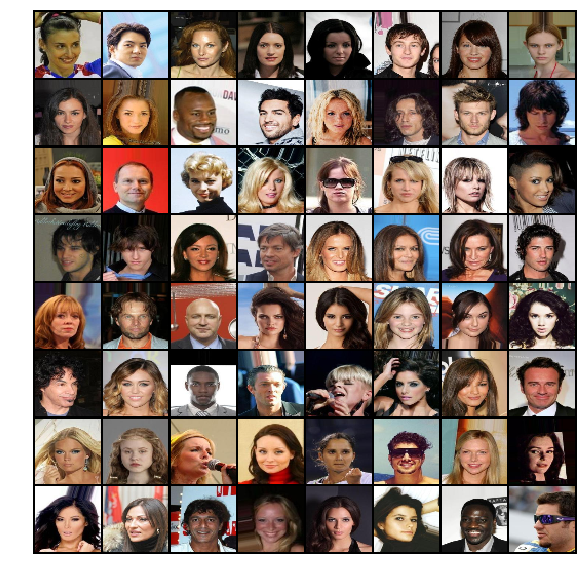

/home/ANT.AMAZON.COM/vishaalk/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


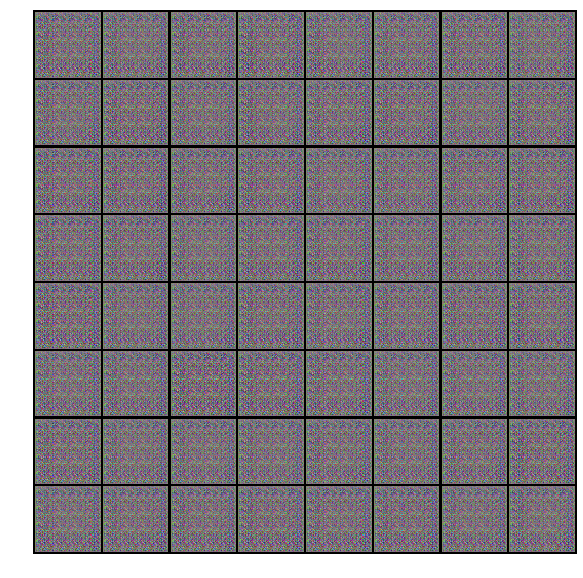

[0/1/125][1/623] Loss_D: 0.2037 Loss_G: 5.5315 D(x): 0.9049 D(G(z)): 0.9993 / 0.0051
[0/1/125][2/623] Loss_D: 0.0984 Loss_G: 6.8498 D(x): 0.9302 D(G(z)): 0.9963 / 0.0015
[0/1/125][3/623] Loss_D: 0.2275 Loss_G: 5.8546 D(x): 0.8473 D(G(z)): 0.9980 / 0.0036
[0/1/125][4/623] Loss_D: 0.5064 Loss_G: 5.7881 D(x): 0.7620 D(G(z)): 0.9980 / 0.0053
[0/1/125][5/623] Loss_D: 0.6866 Loss_G: 5.6270 D(x): 0.6886 D(G(z)): 0.9976 / 0.0055
[0/1/125][6/623] Loss_D: 0.9647 Loss_G: 5.3401 D(x): 0.6008 D(G(z)): 0.9978 / 0.0085
[0/1/125][7/623] Loss_D: 1.2305 Loss_G: 4.9447 D(x): 0.4777 D(G(z)): 0.9978 / 0.0149
[0/1/125][8/623] Loss_D: 0.8251 Loss_G: 4.8177 D(x): 0.5902 D(G(z)): 0.9969 / 0.0198


KeyboardInterrupt: 

In [12]:
epochs = 125 # number of epochs to train for

g_net.collect_params().zero_grad()
d_net.collect_params().zero_grad()
counter = 0
for epoch in range(epochs):
    for i, (d, _ ) in enumerate(train_data):
        
        # Update Discriminator
        data = d.as_in_context(ctx)
        label = nd.ones(batchSize, ctx)
        noise = nd.normal(loc=0, scale=1, shape = (batchSize, nz,1,1),ctx = ctx)
        with autograd.record():            
            
            # Pass Real Data through Network
            output = d_net(data)
            
            # Compute the Error on the Real Data
            D_error = nd.mean(binary_cross_entropy(output,label))
            
            # Compute mean output
            D_x = nd.mean(output)
            
            # Pass Noise through the Generator Network to Counterfeits (Fake Images)
            fake_image = g_net(noise)
            
            # Pass the fake images through the network and Compute the error
            output = d_net(fake_image.detach())
            D_error_fake_image = nd.mean(binary_cross_entropy(output,label*0))
            
            # Mean discriminator output on generated image.
            D_G_z1 = nd.mean(output)
            
            # Combine the errors and back-propegate on both
            D_e = D_error + D_error_fake_image
            D_e.backward()

        D_trainer.step(batchSize)
        
        # Update Generator
        label = nd.ones(batchSize, ctx)
        with autograd.record():
            
            # Pass noise through Generator
            fake_image = g_net(noise)
            
            # Pass Generator counterfeits through Discriminator
            output = d_net(fake_image)
            
            # Compute Loss and Backprop
            G_error = nd.mean(binary_cross_entropy(output,label))
            
            # Mean discriminator output on generated image.
            D_G_z2 = nd.mean(output)
            G_error.backward()
            
        G_trainer.step(batchSize)
        
        
        print('[%d/%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch,counter, epochs, i, len(train_data),
                 D_error.asnumpy(), G_error.asnumpy(), D_x.asnumpy(), D_G_z1.asnumpy(), D_G_z2.asnumpy()))
        trunctate = 1
        if i % (100 * trunctate) == 0:
            image_show(data)
            image_show(fake_image)
        if i % (1000 * trunctate) == 0: 
            filenameG = '%s/G_Net_epoch_%d_%d' % (outf, epoch,counter)
            filenameD = '%s/D_Net_epoch_%d_%d' % (outf, epoch,counter)
            g_net.save_params(filenameG)
            d_net.save_params(filenameD)
            counter = counter + 1
    counter = 0
